In [7]:
import pandas as pd
import numpy as np
import sklearn
import pickle as pkl
import joblib


from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb

In [2]:
#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]
import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

In [3]:
random_state=2021

# Load and check data

In [4]:
df = pd.read_csv('loan-train.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [7]:
# drop unneccessary columns
df.drop(['Loan_ID', 'Gender', 'Property_Area'], axis=1, inplace=True)

In [8]:
# replace Y/N values with 1/0
df.Married = df.Married.replace({"Yes": 1, "No" : 0})
df.Self_Employed = df.Self_Employed.replace({"Yes": 1, "No" : 0})
df.Education = df.Education.replace({"Graduate": 1, "Not Graduate" : 0})

df.Loan_Status = df.Loan_Status.replace({"Y": 1, "N" : 0})

In [9]:
df.loc[(df['Dependents'] == '3+'), 'Dependents']  = 3

In [10]:
# check loan amounts where the loan term is null
df[['ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term']].query('Loan_Amount_Term.isnull()', engine='python')

,ApplicantIncome,LoanAmount,Loan_Amount_Term
19,2600,115.0,NaN
36,1828,100.0,NaN
44,4695,96.0,NaN
45,3410,88.0,NaN
73,4755,95.0,NaN
112,3572,152.0,NaN
165,3707,182.0,NaN
197,1907,120.0,NaN
223,7578,175.0,NaN
232,3189,120.0,NaN


In [11]:
# check the values around that spike
high_amount_df = df[['ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term']].query('LoanAmount > 100')

In [12]:
high_amount_df.describe()

,ApplicantIncome,LoanAmount,Loan_Amount_Term
count,438.000000,438.000000,430.000000
mean,6052.648402,171.200913,343.451163
std,6898.761520,85.918411,63.843896
min,150.000000,101.000000,12.000000
25%,3160.750000,120.000000,360.000000
50%,4294.000000,143.000000,360.000000
75%,6250.000000,185.000000,360.000000
max,81000.000000,700.000000,480.000000


In [13]:
avg_amount = df[['ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term']].query('LoanAmount >= 70 & LoanAmount < 100')

In [14]:
avg_amount.describe()

,ApplicantIncome,LoanAmount,Loan_Amount_Term
count,91.000000,91.000000,86.000000
mean,3694.747253,85.758242,343.674419
std,2621.842489,9.793808,65.336674
min,210.000000,70.000000,36.000000
25%,2550.000000,77.000000,360.000000
50%,3069.000000,88.000000,360.000000
75%,3672.000000,95.000000,360.000000
max,16667.000000,99.000000,480.000000


In [15]:
# check loan amounts where the loan amount is null
df[['ApplicantIncome', 'LoanAmount', 'Loan_Amount_Term']].query('LoanAmount.isnull()', engine='python')

,ApplicantIncome,LoanAmount,Loan_Amount_Term
0,5849,NaN,360.0
35,2275,NaN,360.0
63,4945,NaN,360.0
81,2395,NaN,360.0
95,6782,NaN,360.0
102,13650,NaN,360.0
103,4652,NaN,360.0
113,7451,NaN,360.0
127,3865,NaN,360.0
202,3992,NaN,180.0


In [16]:
mode_loan_360 = df[['LoanAmount', 'Loan_Amount_Term']].query('Loan_Amount_Term == 360')['LoanAmount'].mode().mean()
mode_loan_240 = df[['LoanAmount', 'Loan_Amount_Term']].query('Loan_Amount_Term == 240')['LoanAmount'].mode().mean()
mode_loan_180 = df[['LoanAmount', 'Loan_Amount_Term']].query('Loan_Amount_Term == 180')['LoanAmount'].mode().mean()

In [17]:
df.loc[(df['Loan_Amount_Term'] == 360) & (df["LoanAmount"].isna()), 'LoanAmount'] = mode_loan_360
df.loc[(df['Loan_Amount_Term'] == 240) & (df["LoanAmount"].isna()), 'LoanAmount'] = mode_loan_240
df.loc[(df['Loan_Amount_Term'] == 180) & (df["LoanAmount"].isna()), 'LoanAmount'] = mode_loan_180

In [18]:
# fillnas with the mode

for column in ['Married', 'Self_Employed', 'Dependents', 'Self_Employed', 'Loan_Amount_Term']:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [19]:
# drop the record with apllicant income = 81k
df.drop(index=409, inplace=True)

In [20]:
# drop the record with co-apllicant income = 41k and applicant income = 416
df.drop(index=600, inplace=True)

In [21]:
df.dropna(inplace=True)

In [22]:
for column in ['Married', 'Dependents', 'Self_Employed', 'CoapplicantIncome',
               'LoanAmount', 'Loan_Amount_Term', 'Credit_History']:
    df[column] = df[column].astype('int')

In [23]:
df['LoanAmount'] = df['LoanAmount'] * 1000

In [24]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(16,8))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=20,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()
    plt.show()

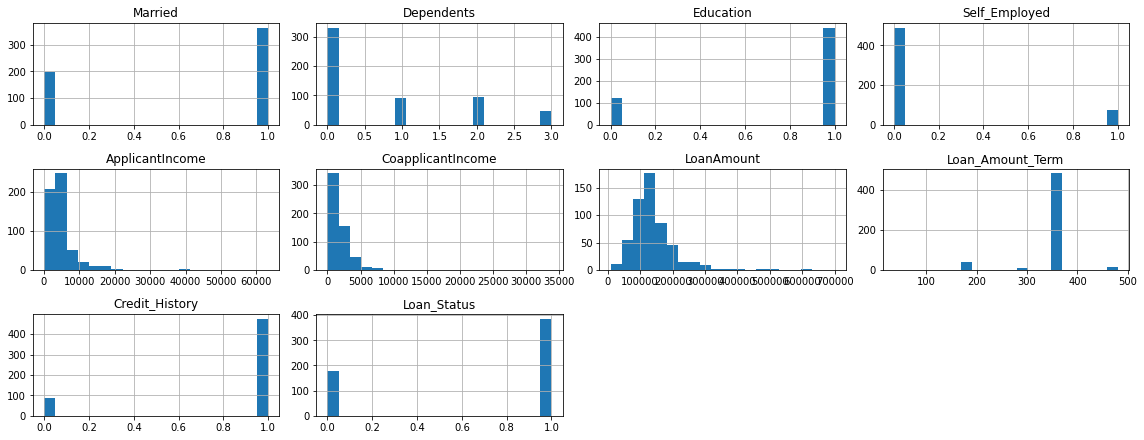

In [25]:
draw_histograms(df, df.columns, 4, 4)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 563 entries, 0 to 613
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Married            563 non-null    int64
 1   Dependents         563 non-null    int64
 2   Education          563 non-null    int64
 3   Self_Employed      563 non-null    int64
 4   ApplicantIncome    563 non-null    int64
 5   CoapplicantIncome  563 non-null    int64
 6   LoanAmount         563 non-null    int64
 7   Loan_Amount_Term   563 non-null    int64
 8   Credit_History     563 non-null    int64
 9   Loan_Status        563 non-null    int64
dtypes: int64(10)
memory usage: 48.4 KB


In [27]:
df.head()

,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,0,0,1,0,5849,0,115000,360,1,1
1,1,1,1,0,4583,1508,128000,360,1,0
2,1,0,1,1,3000,0,66000,360,1,1
3,1,0,0,0,2583,2358,120000,360,1,1
4,0,0,1,0,6000,0,141000,360,1,1


In [28]:
df.describe()

,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000
mean,0.646536,0.747780,0.785080,0.133215,5332.273535,1533.165187,143582.593250,342.564831,0.843694,0.683837
std,0.478470,1.014297,0.411132,0.340109,5406.467737,2473.075892,81504.480036,63.891261,0.363468,0.465391
min,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9000.000000,36.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,2891.500000,0.000000,101500.000000,360.000000,1.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,3814.000000,1125.000000,125000.000000,360.000000,1.000000,1.000000
75%,1.000000,2.000000,1.000000,0.000000,5790.000000,2250.000000,162000.000000,360.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,1.000000,63337.000000,33837.000000,700000.000000,480.000000,1.000000,1.000000


# Bit of feature engineering

In [29]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

In [30]:
# function to get all numerical features, except the one related to Loan Status
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = ['Loan_Status', 'Self_Employed', 'Dependents']
                  
    return [x for x in feats if x not in black_list]


#get feats
feats = get_feats(df)

# Apply feature scaling

scaler = MinMaxScaler()
df[feats] = scaler.fit_transform(df[feats])

In [31]:
df.head()

,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome
0,0.0,0,1.0,0,0.090193,0.000000,0.153401,0.72973,1.0,1,0.071201
1,1.0,1,1.0,0,0.070157,0.044567,0.172214,0.72973,1.0,0,0.075111
2,1.0,0,1.0,1,0.045104,0.000000,0.082489,0.72973,1.0,1,0.025172
3,1.0,0,0.0,0,0.038505,0.069687,0.160637,0.72973,1.0,1,0.056531
4,0.0,0,1.0,0,0.092582,0.000000,0.191027,0.72973,1.0,1,0.073641


# Train

In [32]:
# define X_train
X = df[feats].values
y = df['Loan_Status'].values

In [33]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=random_state, shuffle=True)

In [34]:
# function to run different models
def run_model(model, X, y, cross_val):
    model_name = type(model).__name__

    scores = cross_val_score(model, X, y, cv=cross_val, scoring='accuracy')
    print("{} accuracy: {:.4f}".format(model_name, np.mean(scores)))

In [35]:
# function to plot a learning curve for different models and scoring
def plot_lear_curve(model, X, y, cross_val, scoring, ax):

  model_name = type(model).__name__
  skplt.estimators.plot_learning_curve(model, X, y, cv=cross_val, scoring=scoring,
                                       title=f'{model_name} Learning Curve', ax=ax);

In [36]:
# function to plot a feature importances for different models and scoring
def plot_feature_importances(model, feat_list, ax):

  model_name = type(model).__name__
  skplt.estimators.plot_feature_importances(model, feature_names=df[feat_list].columns,
                                            title=f'{model_name} feature importances', ax=ax)
  plt.xticks(rotation=90)

In [37]:
# define Cross Validation
kf = StratifiedShuffleSplit(n_splits=10, random_state=random_state)

# define simple models for fast testing
Logit_model = LogisticRegression(solver = "liblinear")
DT_model = DecisionTreeClassifier(max_depth=5, random_state=random_state)
RF_model = RandomForestClassifier(max_depth=5, n_estimators=120, random_state=random_state)
XGB_model = xgb.XGBClassifier(max_depth=4, n_estimators=5, eval_metric='error', random_state=random_state)
LGBM_model = lgb.LGBMClassifier(max_depth=4, n_estimators=5, random_state=random_state)

NN_model = MLPClassifier()

# add all models to a list
models = [Logit_model, DT_model, RF_model, XGB_model, LGBM_model, NN_model]

In [38]:
# evaluate models
for model in models:
    run_model(model, X_train, y_train, kf)

LogisticRegression accuracy: 0.8244
DecisionTreeClassifier accuracy: 0.7978
RandomForestClassifier accuracy: 0.8267
XGBClassifier accuracy: 0.8222
LGBMClassifier accuracy: 0.8244
MLPClassifier accuracy: 0.8244


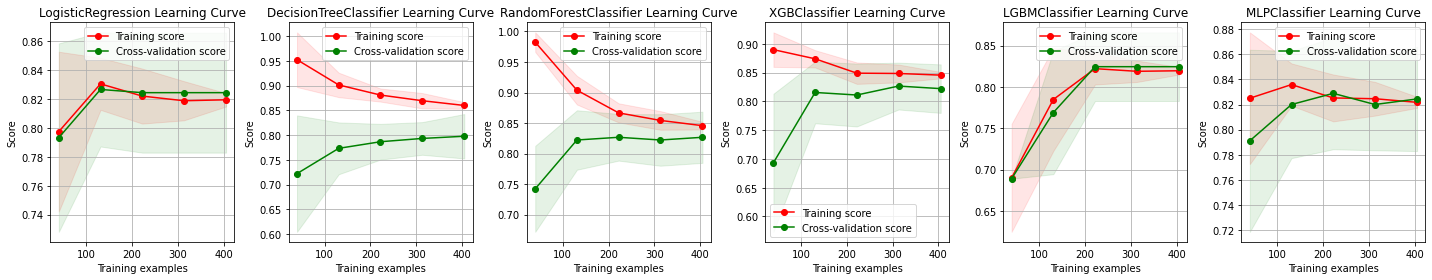

In [39]:
# check the learning curve
fig=plt.figure(figsize=(20,4))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,6,i+1)
    plot_lear_curve(model, X_train, y_train, kf, 'accuracy', ax=ax)
fig.tight_layout()
plt.show()

In [40]:
# fit models
Logit_model.fit(X_train, y_train)
DT_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)
XGB_model.fit(X_train, y_train)
LGBM_model.fit(X_train, y_train)
NN_model.fit(X_train, y_train)

MLPClassifier()

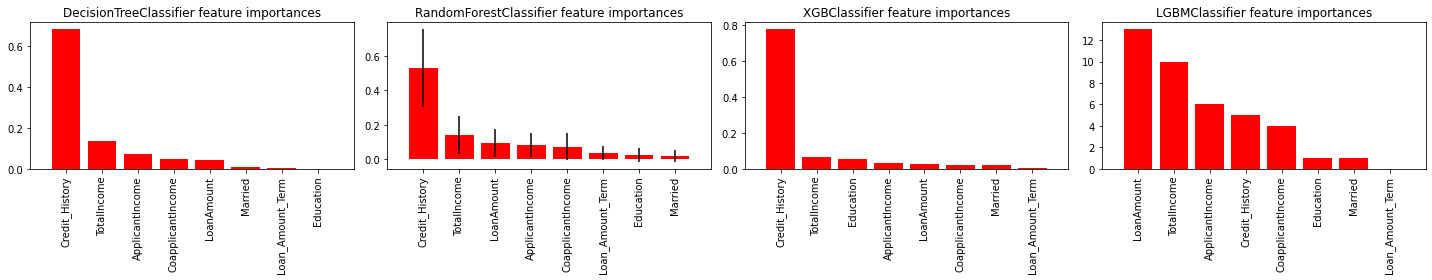

In [41]:
# check feature importances
fig=plt.figure(figsize=(20,4))
for i, model in enumerate(models[1:5]):
    ax=fig.add_subplot(1,4,i+1)
    plot_feature_importances(model, feats, ax=ax)
fig.tight_layout()
plt.show()

# Predict on test data
**from train_test_split**

In [42]:
# predict y
y_predict_Logit = Logit_model.predict(X_test)
y_predict_DT = DT_model.predict(X_test)
y_predict_RF = RF_model.predict(X_test)
y_predict_XGB = XGB_model.predict(X_test)
y_predict_LGBM = LGBM_model.predict(X_test)
y_predict_NN = NN_model.predict(X_test)

# Check f1 and accuracy scores

In [43]:
# calculate f1 score
Logit_f1 = f1_score(y_test, y_predict_Logit)
DT_f1 = f1_score(y_test, y_predict_DT)
RF_f1 = f1_score(y_test, y_predict_RF)
XGB_f1 = f1_score(y_test, y_predict_XGB)
LGBM_f1 = f1_score(y_test, y_predict_LGBM)
NN_f1 = f1_score(y_test, y_predict_NN)

In [44]:
print("----- f1 results on the test data -----")
print("Logit_model: f1: {:.4f}".format(Logit_f1))
print("DT_model: f1: {:.4f}".format(DT_f1))
print("RF_model: f1: {:.4f}".format(RF_f1))
print("XGB_model: f1: {:.4f}".format(XGB_f1))
print("LGBM_model: f1: {:.4f}".format(LGBM_f1))
print("NN_model: f1: {:.4f}".format(NN_f1))

----- f1 results on the test data -----
Logit_model: f1: 0.8671
DT_model: f1: 0.8471
RF_model: f1: 0.8538
XGB_model: f1: 0.8471
LGBM_model: f1: 0.8671
NN_model: f1: 0.8605


In [45]:
# calculate f1 score
Logit_accuracy = accuracy_score(y_test, y_predict_Logit)
DT_accuracy = accuracy_score(y_test, y_predict_DT)
RF_accuracy = accuracy_score(y_test, y_predict_RF)
XGB_accuracy = accuracy_score(y_test, y_predict_XGB)
LGBM_accuracy = accuracy_score(y_test, y_predict_LGBM)
NN_accuracy = accuracy_score(y_test, y_predict_NN)

In [46]:
print("----- accuracy results on the test data -----")
print("Logit_model: accuracy: {:.4f}".format(Logit_accuracy))
print("DT_model: accuracy: {:.4f}".format(DT_accuracy))
print("RF_model: accuracy: {:.4f}".format(RF_accuracy))
print("XGB_model: accuracy: {:.4f}".format(XGB_accuracy))
print("LGBM_model: accuracy: {:.4f}".format(LGBM_accuracy))
print("NN_model: accuracy: {:.4f}".format(NN_accuracy))

----- accuracy results on the test data -----
Logit_model: accuracy: 0.7965
DT_model: accuracy: 0.7699
RF_model: accuracy: 0.7788
XGB_model: accuracy: 0.7699
LGBM_model: accuracy: 0.7965
NN_model: accuracy: 0.7876


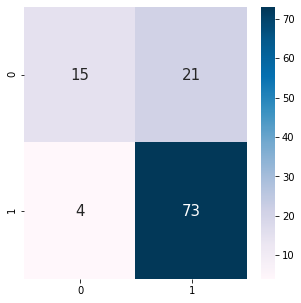

In [47]:
cm = confusion_matrix(y_test, y_predict_RF)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu');

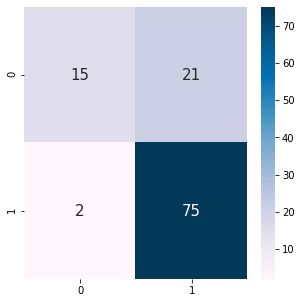

In [48]:
cm = confusion_matrix(y_test, y_predict_LGBM)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu');

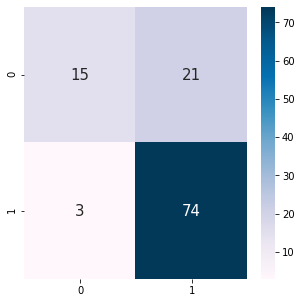

In [49]:
cm = confusion_matrix(y_test, y_predict_NN)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, annot_kws = {'size':15}, cmap = 'PuBu');

# Save LGBM model and MinMaxScaler

In [55]:
# Pickle model 
pd.to_pickle(LGBM_model,'LGBM_model.pickle')
joblib.dump(scaler, 'MinMaxScaler.save')

# Test on random data

In [34]:
def predict_chances():
    
    # Receive data from client
    married = 'False'
    education = 'Graduate'
    applicant_income = 7000
    co_applicant_income = 2000
    loan_amount = 115000
    loan_term = 360
    credit_history = 'True'
    total_income = applicant_income + co_applicant_income

    married = 1 if married == 'True' else 0
    credit_history = 1 if credit_history == 'True' else 0
    education = 1 if credit_history == 'Graduate' else 0

    
    feats = [[married, education, applicant_income,
             co_applicant_income, loan_amount, loan_term,
             credit_history, total_income]]
    
    # Unpickle scaler and scale
    with open('MinMaxScaler.save', 'rb') as f:
        scaler = joblib.load(f)
    feats_scaled = scaler.transform(feats)

    # Unpickle model
    model = pd.read_pickle("LGBM_model.pickle")
    
    # Make prediction
    # predict_proba in our case returns 2 values (equal to the number of categories in target variable = T/F)
    result = model.predict_proba(feats_scaled)[:, 1][0]
    
    return '{:.2%}'.format(result)

In [35]:
predict_chances()

'0.8%'